# **Kaggle Project Code**

---





**Wenxin (Hugo) Xue**  

**SID: 487011**

## Log in Google Colab

In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False

## Deploy GPU

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Nov 29 17:28:49 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


## import required packages

In [ ]:
import sys

import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf
import numpy as np
import os
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications.resnet_v2 import ResNet152V2
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.applications import ResNet50V2, ResNet101V2
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import DenseNet121

from tensorflow.keras.layers import Input, Dropout, Reshape
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import LeakyReLU, PReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.models import Sequential, Model, load_model, save_model
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

## Load dataset

In [ ]:
# file='/content/drive/My Drive/Colab Notebooks/assignment_yourname_class1.ipynb'
PATH = "/content/drive/My Drive/Colab Notebooks/applications-of-deep-learning-wustlfall-2021/city/"
PATH_TRAIN = os.path.join(PATH, "train.csv")
PATH_TEST = os.path.join(PATH, "test.csv")

In [ ]:
df_train = pd.read_csv(PATH_TRAIN)
df_test = pd.read_csv(PATH_TEST)

df_train['filename'] = df_train.id.astype(str) + ".jpg"
df_test['filename'] = df_test.id.astype(str) + ".jpg"

### 1. use train_test_split to sampling dataset

In [ ]:
WIDTH = 150
HEIGHT = 150

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(    
    df_train['filename'].values, df_train['sqft'].values, test_size=0.1) 

df_train_cut = pd.DataFrame({"filename":x_train,"sqft":y_train})
df_validate_cut = pd.DataFrame({"filename":x_test,"sqft":y_test})
print(f"Training shape: {df_train_cut.shape}")
print(f"Validate shape: {df_validate_cut.shape}")

training_datagen = ImageDataGenerator(
  rescale = 1./255,
  horizontal_flip=True,
  # vertical_flip=True,
  fill_mode='nearest')

train_generator = training_datagen.flow_from_dataframe(
        dataframe=df_train_cut,
        directory=PATH,
        x_col="filename",
        y_col="sqft",
        target_size=(HEIGHT, WIDTH),
        batch_size=32, # Keeping the training batch size small USUALLY increases performance
        class_mode='raw')

validation_datagen = ImageDataGenerator(rescale = 1./255)

val_generator = validation_datagen.flow_from_dataframe(
        dataframe=df_validate_cut,
        directory=PATH,
        x_col="filename",
        y_col="sqft",
        target_size=(HEIGHT, WIDTH),
        batch_size=256, # Make the validation batch size as large as you have memory for
        class_mode='raw')

Training shape: (21598, 2)
Validate shape: (2400, 2)
Found 21598 validated image filenames.
Found 2400 validated image filenames.


### 2. simply split train and test dataset by 9:1

In [ ]:
TRAIN_PCT = 0.9
TRAIN_CUT = int(len(df_train) * TRAIN_PCT)

df_train_cut = df_train[0:TRAIN_CUT]
df_validate_cut = df_train[TRAIN_CUT:]

print(f"Training size: {len(df_train_cut)}")
print(f"Validate size: {len(df_validate_cut)}")

WIDTH = 150
HEIGHT = 150

training_datagen = ImageDataGenerator(
  rescale = 1./255,
  horizontal_flip=True,
  # vertical_flip=True,
  fill_mode='nearest')

train_generator = training_datagen.flow_from_dataframe(
        dataframe=df_train_cut,
        directory=PATH,
        x_col="filename",
        y_col="sqft",
        target_size=(HEIGHT, WIDTH),
        batch_size=32, # Keeping the training batch size small USUALLY increases performance
        class_mode='raw')

validation_datagen = ImageDataGenerator(rescale = 1./255)

val_generator = validation_datagen.flow_from_dataframe(
        dataframe=df_validate_cut,
        directory=PATH,
        x_col="filename",
        y_col="sqft",
        target_size=(HEIGHT, WIDTH),
        batch_size=256, # Make the validation batch size as large as you have memory for
        class_mode='raw')

Training size: 21598
Validate size: 2400
Found 21598 validated image filenames.
Found 2400 validated image filenames.


## Try to build different types of model

In [ ]:
# sequential model
# model = Sequential(
#     [
#      Conv2D(32, (3,3), activation='relu', input_shape=(HEIGHT, WIDTH, 3),padding="same"),
#      MaxPooling2D(pool_size=(2,2)),
#      Conv2D(64, (3,3), activation='relu', padding="same"),
#      Conv2D(64, (3,3), activation='relu'),
#      MaxPooling2D(pool_size=(2,2)),
#      Conv2D(128, (3,3), activation='relu',padding="same"),
#      Conv2D(128, (3,3), activation='relu'),
#      MaxPooling2D(pool_size=(4,4)),
#      Flatten(),
#      Dense(1024, activation='relu'),
#      Dense(512, activation='relu'),
#      Dense(256, activation='relu'),
#      Dense(128, activation='relu'),
#      Dense(64, activation='relu'),
#      Dense(1, activation='linear')
#     ]
# )
# model.summary()
################################################################################
# Xception-1 rmse=>500
input_tensor = Input(shape=(HEIGHT, WIDTH, 3))
base_model = Xception(
    include_top=False, weights='imagenet', input_tensor=input_tensor,
    classifier_activation='relu'
)

base_model.trainable=True
x=base_model.layers[-1].output
x=GlobalAveragePooling2D()(x)

x = Dense(1536,activation='relu')(x)
x = Dense(1536,activation='relu')(x)
x = Dense(728,activation='relu')(x)
x = Dense(728,activation='relu')(x)

output=Dense(1,activation='linear')(x)
model=Model(inputs=input_tensor,outputs=output)
model.summary() 
###############################################################################
# Xception-2
# input_tensor = Input(shape=(HEIGHT, WIDTH, 3))
# base_model = Xception(
#     include_top=False, weights='imagenet', input_tensor=input_tensor,
#     classifier_activation='relu'
# )

# base_model.trainable=True
# x=base_model.output
# x=GlobalAveragePooling2D()(x)

# x = Dense(1024,activation='relu')(x)
# x = Dense(1024,activation='relu')(x)
# x = Dense(512,activation='relu')(x)
# x = Dense(64,activation='relu')(x)

# output=Dense(1,activation='linear')(x)
# model=Model(inputs=input_tensor,outputs=output)
# model.summary()
#############################################################################
# VGG16-2
# input_tensor = Input(shape=(HEIGHT, WIDTH, 3))
# base_model = VGG16(
#     include_top=False, weights='imagenet', input_tensor=input_tensor,
#     classifier_activation='relu'
# )

# base_model.trainable=True
# x=base_model.output
# x=GlobalAveragePooling2D()(x)

# x = Dense(512,activation='relu')(x)
# x = Dense(512,activation='relu')(x)
# x = Dense(256,activation='relu')(x)
# x = Dense(256,activation='relu')(x)
# x = Dense(64,activation='relu')(x)

# output=Dense(1,activation='linear')(x)
# model=Model(inputs=input_tensor,outputs=output)
# model.summary()
##########################################################
# input_tensor = Input(shape=(HEIGHT, WIDTH, 3))
# base_model = DenseNet121(
#     include_top=False, weights='imagenet', input_tensor=input_tensor
# )

# base_model.trainable=True
# x=base_model.output
# x=GlobalAveragePooling2D()(x)

# x = Dense(512,activation='relu')(x)
# x = Dense(512,activation='relu')(x)
# x = Dense(256,activation='relu')(x)
# x = Dense(256,activation='relu')(x)
# x = Dense(64,activation='relu')(x)
# x = Dense(64,activation='relu')(x)

# output=Dense(1,activation='linear')(x)
# model=Model(inputs=input_tensor,outputs=output)
# model.summary()
####################################################
# input_tensor = Input(shape=(HEIGHT, WIDTH, 3))
# base_model = ResNet152V2(
#     include_top=False, weights='imagenet', input_tensor=input_tensor,
#     classifier_activation='relu'
# )

# x=base_model.output
# x=GlobalAveragePooling2D()(x)

# x = Dense(1024,activation='relu')(x)
# x = Dense(1024,activation='relu')(x)
# # x = Dense(64,activation='relu')(x)

# output=Dense(1,activation='linear')(x)
# model=Model(inputs=input_tensor,outputs=output)
# model.summary()
###########################################################
# input_tensor = Input(shape=(HEIGHT, WIDTH, 3))
# base_model = Xception(
#     include_top=False, weights=None, input_tensor=input_tensor,
#     classifier_activation='relu'
# )

# x=base_model.output
# x=GlobalAveragePooling2D()(x)

# x = Dense(1024,activation='relu')(x)
# x = Dense(1024,activation='relu')(x)

# output=Dense(1)(x)
# model=Model(inputs=input_tensor,outputs=output)
# model.summary()

83697664/83683744 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 74, 74, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                             

### Model Training
- metrics: rmse 
- learning rate: 1e-4 or 1e-5
- Adam
- model_checkpoint: save best model
- lr_reduce: 1e-7

In [ ]:
STEP_SIZE_VALID=val_generator.n//val_generator.batch_size

model.compile(loss = 'mean_squared_error', optimizer=Adam(learning_rate=1e-5), metrics=[RootMeanSquaredError(name="rmse")])
model_checkpoint=ModelCheckpoint(os.path.join(PATH, 'xception_bestmodel.h5'),monitor="val_loss",save_best_only=True,mode="min",verbose=1)
lr_reduce = ReduceLROnPlateau(monitor='val_loss',factor=0.6,patience=50,verbose=1,mode='auto',min_lr=1e-7)
callback = [model_checkpoint,lr_reduce]
model.fit(train_generator, epochs=500, steps_per_epoch=250, validation_data = val_generator, 
          callbacks=callback, verbose = 1, validation_steps=STEP_SIZE_VALID)

model.load_weights(os.path.join(PATH, 'xception_bestmodel.h5'))

submit_datagen = ImageDataGenerator(rescale = 1./255)

submit_generator = submit_datagen.flow_from_dataframe(
        dataframe=df_test,
        directory=PATH,
        x_col="filename",
        batch_size = 1,
        shuffle = False,
        target_size=(HEIGHT, WIDTH),
        class_mode=None)

submit_generator.reset()
best_pred = model.predict(submit_generator,steps=len(df_test))
best_df_submit = pd.DataFrame({"id":df_test['id'],'sqft':best_pred[:,0].flatten()})
best_df_submit.to_csv("/content/drive/My Drive/Colab Notebooks/applications-of-deep-learning-wustlfall-2021/best_submit.csv",index = False)

Epoch 1/500
250/250 [==============================] - ETA: 0s - loss: 31025524.0000 - rmse: 5570.0557
Epoch 00001: val_loss improved from inf to 5490572.50000, saving model to /content/drive/My Drive/Colab Notebooks/applications-of-deep-learning-wustlfall-2021/city/xception_bestmodel.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


250/250 [==============================] - 69s 253ms/step - loss: 31025524.0000 - rmse: 5570.0557 - val_loss: 5490572.5000 - val_rmse: 2343.1970 - lr: 1.0000e-05
Epoch 2/500
250/250 [==============================] - ETA: 0s - loss: 2532085.2500 - rmse: 1591.2527
Epoch 00002: val_loss improved from 5490572.50000 to 1150573.12500, saving model to /content/drive/My Drive/Colab Notebooks/applications-of-deep-learning-wustlfall-2021/city/xception_bestmodel.h5
250/250 [==============================] - 62s 248ms/step - loss: 2532085.2500 - rmse: 1591.2527 - val_loss: 1150573.1250 - val_rmse: 1072.6477 - lr: 1.0000e-05
Epoch 3/500
250/250 [==============================] - ETA: 0s - loss: 1055374.6250 - rmse: 1027.3142
Epoch 00003: val_loss improved from 1150573.12500 to 1027355.87500, saving model to /content/drive/My Drive/Colab Notebooks/applications-of-deep-learning-wustlfall-2021/city/xception_bestmodel.h5
250/250 [==============================] - 62s 247ms/step - loss: 1055374.6250 - 

### Build ensemble model: improving prediction accuracy

- resnet
- xception
- vgg

In [ ]:
WIDTH = 150
HEIGHT = 150

def build_resnet():
  input_tensor = Input(shape=(HEIGHT, WIDTH, 3))
  base_model = ResNet152V2(
      include_top=False, weights='imagenet', input_tensor=input_tensor,
      classifier_activation='relu'
  )

  x=base_model.output
  x=GlobalAveragePooling2D()(x)

  x = Dense(1024,activation='relu')(x)
  x = Dense(1024,activation='relu')(x)

  output=Dense(1,activation='linear')(x)
  model_resnet=Model(inputs=input_tensor,outputs=output)
  return model_resnet

def build_vgg():
  input_tensor = Input(shape=(HEIGHT, WIDTH, 3))
  base_model = VGG16(
      include_top=False, weights='imagenet', input_tensor=input_tensor,
      classifier_activation='relu'
  )

  x=base_model.output
  x=GlobalAveragePooling2D()(x)

  x = Dense(1024,activation='relu')(x)
  x = Dense(1024,activation='relu')(x)

  output=Dense(1,activation='linear')(x)
  model_vgg=Model(inputs=input_tensor,outputs=output)
  return model_vgg

def build_xception():
  input_tensor = Input(shape=(HEIGHT, WIDTH, 3))
  base_model = Xception(
      include_top=False, weights='imagenet', input_tensor=input_tensor,
      classifier_activation='relu'
  )

  x=base_model.output
  x=GlobalAveragePooling2D()(x)

  x = Dense(1024,activation='relu')(x)
  x = Dense(1024,activation='relu')(x)

  output=Dense(1,activation='linear')(x)
  model_xception=Model(inputs=input_tensor,outputs=output)
  return model_xception

**Ensemble Models**
- kfold: try 5 or 10
- for every model, for every fold, train the model
- predict submit file for every model and every fold, calculate the average value

In [ ]:
x = df_train["filename"].values
y = df_train["sqft"].values
x_submit = df_test["filename"].values

oos_y = []
oos_pred = []

models = [build_vgg(),build_xception()]
dataset_blend_train = np.zeros((x.shape[0], len(models)))
dataset_blend_test = np.zeros((x_submit.shape[0], len(models)))
submit_datagen = ImageDataGenerator(rescale = 1./255)
submit_generator = submit_datagen.flow_from_dataframe(
        dataframe=df_test,
        directory=PATH,
        x_col="filename",
        batch_size = 1,
        shuffle = False,
        target_size=(HEIGHT, WIDTH),
        class_mode=None)
submit_generator.reset()

kf = KFold(3)
folds = list(kf.split(x))
fold=0

for j, model in enumerate(models):
  print("Model: {} : {}".format(j, model))
  fold_sums = np.zeros((x_submit.shape[0], len(folds)))
  total_rmse = 0
  for i, (train, test) in enumerate(folds):
    #training set
    train_cut = df_train.loc[train]
    #testing set
    val_cut = df_train.loc[test]

    training_datagen = ImageDataGenerator(
      rescale = 1./255,
      horizontal_flip=True,
      fill_mode='nearest')

    train_generator = training_datagen.flow_from_dataframe(
          dataframe= train_cut,
          directory=PATH,
          x_col="filename",
          y_col="sqft",
          target_size=(HEIGHT, WIDTH),
          batch_size=32,
          class_mode='raw')

    validation_datagen = ImageDataGenerator(rescale = 1./255)

    val_generator = validation_datagen.flow_from_dataframe(
          dataframe=val_cut,
          directory=PATH,
          x_col="filename",
          y_col="sqft",
          target_size=(HEIGHT, WIDTH),
          batch_size=256, # Make the validation batch size as large as you have memory for
          class_mode='raw')  
    
    STEP_SIZE_VALID=val_generator.n//val_generator.batch_size

    model.compile(loss = 'mean_squared_error', optimizer=Adam(learning_rate=1e-5), metrics=[RootMeanSquaredError(name="rmse")])
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=20, verbose=1, mode='min',
            restore_best_weights=True)
    # model_checkpoint1=ModelCheckpoint(
    #     os.path.join(PATH, 'blend{}_bestmodel.h5'.format(j)),
    #     monitor="val_loss",save_best_only=True,mode="min",verbose=1)
    # model_checkpoint2=ModelCheckpoint(os.path.join(PATH, 'resnet152_latestmodel.h5'),monitor="val_loss",save_best_only=False,mode="min",
    #                                       save_weights_only=True, verbose=0)
    lr_reduce = ReduceLROnPlateau(monitor='val_loss',factor=0.6,patience=20,verbose=1,mode='auto',min_lr=1e-7)
    callback = [monitor,model_checkpoint1,lr_reduce]
    model.fit(train_generator, epochs=50, steps_per_epoch=250, validation_data = val_generator, 
              callbacks=callback, verbose = 1, validation_steps=STEP_SIZE_VALID)

    pred = model.predict(val_generator)
    dataset_blend_train[test, j] = pred[:, 0]
    pred2 = model.predict(submit_generator,steps=len(df_test))
    fold_sums[:, i] = pred2[:, 0]

    rmse = np.sqrt(mean_squared_error(val_cut["sqft"].values, pred[:,0]))
    total_rmse+=rmse
    print("Fold #{}: rmse={}".format(i,rmse))
  
  print("{}: Mean rmse={}".format(model.__class__.__name__,total_rmse/len(folds)))
  dataset_blend_test[:, j] = fold_sums.mean(1)

print()
print("Blending models.")

from sklearn.ensemble import BaggingRegressor
blend = BaggingRegressor(SVR())
blend.fit(dataset_blend_train, y)
submit_data = blend.predict(dataset_blend_test)
best_df_submit = pd.DataFrame({"id":df_test['id'],'sqft':submit_data.flatten()})
best_df_submit.to_csv("/content/drive/My Drive/Colab Notebooks/applications-of-deep-learning-wustlfall-2021/best_df_submit0.csv",index = False)
best_df_submit.head()

Found 1070 validated image filenames.
Model: 0 : <keras.engine.functional.Functional object at 0x7fb405f61a10>
Found 15998 validated image filenames.
Found 8000 validated image filenames.
Epoch 1/50
250/250 [==============================] - ETA: 0s - loss: 9884918.0000 - rmse: 3144.0291
Epoch 00001: val_loss did not improve from 38344.63281
250/250 [==============================] - 80s 314ms/step - loss: 9884918.0000 - rmse: 3144.0291 - val_loss: 2978513.2500 - val_rmse: 1725.8369 - lr: 1.0000e-05
Epoch 2/50
250/250 [==============================] - ETA: 0s - loss: 2486400.5000 - rmse: 1576.8324
Epoch 00002: val_loss did not improve from 38344.63281
250/250 [==============================] - 76s 305ms/step - loss: 2486400.5000 - rmse: 1576.8324 - val_loss: 1894992.7500 - val_rmse: 1376.5873 - lr: 1.0000e-05
Epoch 3/50
250/250 [==============================] - ETA: 0s - loss: 1426387.3750 - rmse: 1194.3146
Epoch 00003: val_loss did not improve from 38344.63281
250/250 [=============

KeyboardInterrupt: ignored

#### use regression model to predict submit file's result

In [ ]:
from sklearn.linear_model import SGDRegressor
blend = SGDRegressor()
blend.fit(dataset_blend_train, y)
submit_data = blend.predict(dataset_blend_test)
best_df_submit = pd.DataFrame({"id":df_test['id'],'sqft':submit_data.flatten()})
best_df_submit.to_csv("/content/drive/My Drive/Colab Notebooks/applications-of-deep-learning-wustlfall-2021/best_df_submit2.csv",index = False)

In [ ]:
from sklearn.svm import SVR
blend = SVR()
blend.fit(dataset_blend_train, y)
submit_data = blend.predict(dataset_blend_test)
best_df_submit = pd.DataFrame({"id":df_test['id'],'sqft':submit_data.flatten()})
best_df_submit.to_csv("/content/drive/My Drive/Colab Notebooks/applications-of-deep-learning-wustlfall-2021/best_df_submit3.csv",index = False)
best_df_submit.head()

,id,sqft
0,24000,5822.377037
1,24001,5835.473316
2,24002,5834.567900
3,24003,5817.118924
4,24004,5822.497574


In [ ]:
from sklearn.neighbors import KNeighborsRegressor
blend = KNeighborsRegressor(n_neighbors=5)
blend.fit(dataset_blend_train, y)
submit_data = blend.predict(dataset_blend_test)
best_df_submit = pd.DataFrame({"id":df_test['id'],'sqft':submit_data.flatten()})
best_df_submit.to_csv("/content/drive/My Drive/Colab Notebooks/applications-of-deep-learning-wustlfall-2021/best_df_submit5.csv",index = False)
best_df_submit.head()

,id,sqft
0,24000,4675.2
1,24001,6828.4
2,24002,5757.0
3,24003,4643.0
4,24004,5999.6


In [ ]:
from sklearn.ensemble import BaggingRegressor
blend = BaggingRegressor(SVR())
blend.fit(dataset_blend_train, y)
submit_data = blend.predict(dataset_blend_test)
best_df_submit = pd.DataFrame({"id":df_test['id'],'sqft':submit_data.flatten()})
best_df_submit.to_csv("/content/drive/My Drive/Colab Notebooks/applications-of-deep-learning-wustlfall-2021/best_df_submit4.csv",index = False)
best_df_submit.head()

,id,sqft
0,24000,5835.957249
1,24001,5845.931830
2,24002,5830.816485
3,24003,5830.907638
4,24004,5837.341104


In [ ]:
from sklearn import tree
blend = tree.DecisionTreeRegressor()
blend.fit(dataset_blend_train, y)
submit_data = blend.predict(dataset_blend_test)
best_df_submit = pd.DataFrame({"id":df_test['id'],'sqft':submit_data.flatten()})
best_df_submit.to_csv("/content/drive/My Drive/Colab Notebooks/applications-of-deep-learning-wustlfall-2021/best_df_submit6.csv",index = False)
best_df_submit.head()

,id,sqft
0,24000,5746.0
1,24001,7105.0
2,24002,7947.0
3,24003,6026.0
4,24004,4804.0


In [ ]:
# from sklearn.model_selection import KFold
# from sklearn.metrics import mean_squared_error

# x = df_train["filename"].values
# oos_y = []
# oos_pred = []

# kf = KFold(10)
# fold=0
# for train, test in kf.split(x):
#   fold+=1
#   print(f"fold #{fold}")

#   train_cut = df_train.loc[train]
#   val_cut = df_train.loc[test]

#   training_datagen = ImageDataGenerator(
#     rescale = 1./255,
#     horizontal_flip=True,
#     fill_mode='nearest')

#   train_generator = training_datagen.flow_from_dataframe(
#         dataframe= train_cut,
#         directory=PATH,
#         x_col="filename",
#         y_col="sqft",
#         target_size=(150, 150),
#         batch_size=32,
#         class_mode='raw')

#   validation_datagen = ImageDataGenerator(rescale = 1./255)

#   val_generator = validation_datagen.flow_from_dataframe(
#         dataframe=val_cut,
#         directory=PATH,
#         x_col="filename",
#         y_col="sqft",
#         target_size=(150, 150),
#         batch_size=256, # Make the validation batch size as large as you have memory for
#         class_mode='raw')

#   STEP_SIZE_VALID=val_generator.n//val_generator.batch_size

#   model.compile(loss = 'mean_squared_error', optimizer=Adam(learning_rate=1e-5), metrics=[RootMeanSquaredError(name="rmse")])
#   monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=20, verbose=1, mode='min',
#           restore_best_weights=True)
#   model_checkpoint1=ModelCheckpoint(os.path.join(PATH, 'resnet152_bestmodel.h5'),monitor="val_loss",save_best_only=True,mode="min",verbose=1)
#   # model_checkpoint2=ModelCheckpoint(os.path.join(PATH, 'resnet152_latestmodel.h5'),monitor="val_loss",save_best_only=False,mode="min",
#   #                                       save_weights_only=True, verbose=0)
#   lr_reduce = ReduceLROnPlateau(monitor='val_loss',factor=0.6,patience=20,verbose=1,mode='auto',min_lr=1e-7)
#   callback = [monitor,model_checkpoint1,model_checkpoint2,lr_reduce]
#   model.fit(train_generator, epochs=100, steps_per_epoch=250, validation_data = val_generator, 
#             callbacks=callback, verbose = 1, validation_steps=STEP_SIZE_VALID)

#   model.load_weights(os.path.join(PATH, 'resnet152_bestmodel.h5'))
#   pred = model.predict(val_generator)
    
#   oos_y.append(df_train.loc[test,"sqft"].values)
#   oos_pred.append(pred)

#   score = np.sqrt(mean_squared_error(pred,df_train.loc[test,"sqft"].values))
#   print(f"Fold score (RMSE): {score}")

# # Build the oos prediction list and calculate the error.
# oos_y = np.concatenate(oos_y)
# oos_pred = np.concatenate(oos_pred)
# score = np.sqrt(mean_squared_error(oos_pred,oos_y))
# print(f"Final, out of sample score (RMSE): {score}")  

## Bayesian-Optimization parameters tuning

**reminder: it takes a lot GPU, and will be crashed if the GPU and RAM are full**


##### save pre-trained model results

In [ ]:
# feature_train = model0.predict(train_generator)
# feature_val = model0.predict(val_generator)
# np.save("/content/drive/My Drive/Colab Notebooks/applications-of-deep-learning-wustlfall-2021/feature_train.npy",feature_train)
# np.save("/content/drive/My Drive/Colab Notebooks/applications-of-deep-learning-wustlfall-2021/feature_val.npy",feature_val)

In [ ]:
# feature_train.shape

(21598, 5, 5, 2048)

In [ ]:
# STEP_SIZE_VALID=val_generator.n//val_generator.batch_size

# base_model.compile(loss = 'mean_squared_error', optimizer=Adam(learning_rate=1e-4), metrics=[RootMeanSquaredError(name="rmse")])
# monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=50, verbose=1, mode='auto',
#         restore_best_weights=True)
# basemodel_checkpoint=ModelCheckpoint('basemodel.h5',monitor="val_loss",save_best_only=True,mode="max",
#                                       save_weights_only=True, verbose=1)
# lr_reduce = ReduceLROnPlateau(monitor='val_loss',factor=0.6,patience=30,verbose=1,mode='auto',min_lr=1e-7)
# base_model.fit(train_generator, epochs=300, steps_per_epoch=250, validation_data = val_generator, 
#                callbacks=[monitor,basemodel_checkpoint,lr_reduce], verbose = 1, validation_steps=STEP_SIZE_VALID)

# if os.path.isfile('basemodel.h5'):
#     base_model.load_weights('basemodel.h5')

##### clear RAM and GPU, start the following steps

In [ ]:
# feature_val = np.load("/content/drive/My Drive/Colab Notebooks/applications-of-deep-learning-wustlfall-2021/feature_val.npy")
# feature_train = np.load("/content/drive/My Drive/Colab Notebooks/applications-of-deep-learning-wustlfall-2021/feature_train.npy")

##### build the model that should be tuned

In [ ]:
# hyperparameters
def build_model(neuronCount=256, learning_rate=1e-4,l2=1e-3,activation=3,rate=0.7,layer_number=2):
  initializer = he_normal()
  input_tensor = Input(shape=(HEIGHT, WIDTH, 3)) # !caution here
  base = basemodel(input_tensor=input_tensor)
  x=GlobalAveragePooling2D()(base.output)

  activation_dict={1:"relu",2:"elu",3:"tanh"}
  layer = 0
  while layer<layer_number:
    x = Dense(units=neuronCount,activation=activation_dict[activation],
                  kernel_initializer=initializer,kernel_regularizer=tensorflow.keras.regularizers.l2(l2=l2))(x)
    x=Dropout(rate)(x)
    layer+=1

  output=Dense(1,activation="linear")(x)
  model=Model(inputs=input_tensor,outputs=output)
  model.compile(loss = 'mean_squared_error', optimizer=Adam(learning_rate=learning_rate), metrics=[RootMeanSquaredError(name="rmse")])
  lr_reduce = tensorflow.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.6,patience=30,verbose=1,mode='min',min_lr=1e-7)
  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=50, verbose=1, mode='min',
                          restore_best_weights=True)
  checkpoint = ModelCheckpoint('city.h5',monitor='val_loss',verbose=1,save_weights_only=True,save_best_only=True,
                                mode='min',save_freq='epoch')
  return model, lr_reduce, monitor, checkpoint

##### build training model

In [ ]:
def fit_model(model, lr_reduce, monitor, checkpoint):
  """function that trains the head classifier"""
  history = model.fit(feature_train, df_train_cut["sqft"],
                      batch_size=32,
                      epochs=50,
                      verbose=1,
                      callbacks=[lr_reduce, monitor, checkpoint],
                      validation_data=(feature_val, df_validate_cut['sqft']),
                      shuffle=True)
  return history

##### evaluate the model and use the evaluation to optimize the model

In [ ]:
def evaluate_model(model):
  """function that evaluates the head classifier"""
  evaluation = model.evaluate(feature_val, df_validate_cut['sqft'])
  return evaluation

##### tuning parameters


Hyperparameters: [[1.024e+03 1.000e-04 1.000e-05 2.000e+00 6.000e-01 4.000e+00]]
Epoch 1/50
673/675 [============================>.] - ETA: 0s - loss: 7636229.0000 - rmse: 2763.3728
Epoch 00001: val_loss improved from inf to 3888389.50000, saving model to city.h5
675/675 [==============================] - 6s 7ms/step - loss: 7628205.5000 - rmse: 2761.9207 - val_loss: 3888389.5000 - val_rmse: 1971.8999 - lr: 1.0000e-04
Epoch 2/50
673/675 [============================>.] - ETA: 0s - loss: 4191992.5000 - rmse: 2047.4355
Epoch 00002: val_loss improved from 3888389.50000 to 3817821.00000, saving model to city.h5
675/675 [==============================] - 4s 6ms/step - loss: 4193941.0000 - rmse: 2047.9114 - val_loss: 3817821.0000 - val_rmse: 1953.9244 - lr: 1.0000e-04
Epoch 3/50
672/675 [============================>.] - ETA: 0s - loss: 4098836.2500 - rmse: 2024.5582
Epoch 00003: val_loss improved from 3817821.00000 to 3808268.75000, saving model to city.h5
675/675 [========================

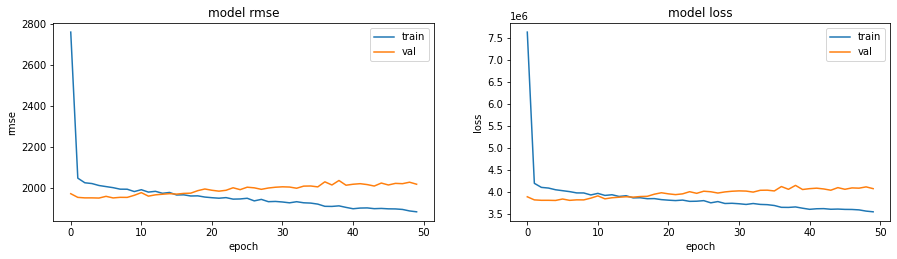


Hyperparameters: [[1.024e+03 1.000e-04 1.000e-04 2.000e+00 6.000e-01 4.000e+00]]
75/75 [==============================] - 0s 5ms/step - loss: 4073042.0000 - rmse: 2018.1779


InternalError: ignored

In [ ]:
from tensorflow.keras.backend import clear_session
!pip install GPy
!pip install GPyOpt
import GPy
import GPyOpt
from GPyOpt.methods import BayesianOptimization
from matplotlib import pyplot as plt
# define the kernel for the Bayesian surrogate model using the "radial basis function" (RBF)
kernel = GPy.kern.RBF(input_dim=1, variance=1.0, lengthscale=1.0)
# hyperparameter bounds
bounds = [
          {'name': 'neuronCount', 'type': 'discrete', 'domain': (256,512,1024)},
          {'name': 'learning_rate', 'type': 'discrete', 'domain': (1e-4, 1e-5)}, 
          {'name': 'l2', 'type': 'discrete', 'domain': (1e-4,1e-5)}, 
          {'name': 'activation', 'type': 'discrete', 'domain': (1, 2, 3)}, 
          {'name': 'rate', 'type': 'discrete', 'domain': (0.5,0.6,0.7)},
          {'name': 'layer_number', 'type': 'discrete', 'domain': (4,5,6)}
          ]
# Note: 'activation' domain parameters (1, 2, 3) correspond to strings ('relu', 'elu', 'tanh'); dictionary defined in build_model()
# objective function for the model optimization:
def f(x):
  """objective function of the Bayesian surrogate model"""
  print()
  print("Hyperparameters:", x)
  # Retrieve 'accuracy' from the previously saved model
  try:
    previous_best_model = load_model('city.h5')
    previous_evaluation = evaluate_model(previous_best_model)
  except Exception:
    previous_best_model = None
  model, lr_reduce, monitor, checkpoint = build_model(
                                        neuronCount=int(x[:,0]),
                                        learning_rate=float(x[:,1]),
                                        l2=float(x[:,2]),
                                        activation=int(x[:,3]),
                                        rate=float(x[:,4]),
                                        layer_number=int(x[:,5])
                                        )
  history = fit_model(model, lr_reduce, monitor, checkpoint)
  evaluation = evaluate_model(model)
  print()
  print("parameters:\t{0} LOSS:\t{1} \t rmse:\t{2}".format(x,evaluation[0], evaluation[1]))
  print(evaluation)
  print()
  # compare previous and current validation accuracies
  if not previous_best_model:
    save_model(model, 'city.h5', overwrite=False, include_optimizer=True)
  if previous_best_model and evaluation[-1] < previous_evaluation[-1]:
    save_model(model, 'city.h5', overwrite=True,include_optimizer=True)

  # Get the dictionary containing each metric and the loss for each epoch
  # history_dict = history.history
  # print(history_dict)
  def plot_history(history):
    """function that plots the model loss and accuracy"""
    plt.figure(1, figsize = (15,8))
    plt.subplot(221)
    plt.plot(history.history['rmse'])
    plt.plot(history.history['val_rmse'])
    plt.title('model rmse')
    plt.ylabel('rmse')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'])
    plt.subplot(222)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'])
    plt.show()
  # # plot the model accuracy and loss results
  plot_history(history)
  # delete the instantiated models from memory and clear the session
  del model
  del previous_best_model
  clear_session()
  return evaluation[1]

optimizer = BayesianOptimization(f=f,
                                 domain=bounds,
                                 model_type='GP',
                                 kernel=kernel,
                                 acquisition_type ='EI',
                                 acquisition_jitter = 0.01,
                                 exact_feval=False,
                                 normalize_Y=False,
                                #  maximize=True, we try to minimize the loss/rmse, so keep false here
                                 verbosity=True)

print()
print("=====================")
print("=====================")
print()
optimizer.run_optimization(max_iter=30, verbosity=False)
optimizer.plot_acquisition()
optimizer.plot_convergence()
optimizer.save_report('bayes_opt.txt')

##### load the model to predict and submit file

In [ ]:
best_model = load_model('city.h5')

submit_datagen = ImageDataGenerator(rescale = 1./255)

submit_generator = submit_datagen.flow_from_dataframe(
        dataframe=df_test,
        directory=PATH,
        x_col="filename",
        batch_size = 1,
        shuffle = False,
        target_size=(HEIGHT, WIDTH),
        class_mode=None)

submit_generator.reset()
pred = best_model.predict(submit_generator,steps=len(df_test))
df_submit = pd.DataFrame({"id":df_test['id'],'sqft':pred[:,0].flatten()})
df_submit.to_csv("/content/drive/My Drive/Colab Notebooks/applications-of-deep-learning-wustlfall-2021/submit11.csv",index = False)

Epoch 1/300
250/250 [==============================] - 66s 239ms/step - loss: 7363987.5000 - rmse: 2713.6667 - val_loss: 30798560.0000 - val_rmse: 5549.6450
Epoch 2/300
250/250 [==============================] - 58s 230ms/step - loss: 1669661.0000 - rmse: 1292.1537 - val_loss: 30058838.0000 - val_rmse: 5482.5942
Epoch 3/300
250/250 [==============================] - 58s 233ms/step - loss: 1517575.3750 - rmse: 1231.8990 - val_loss: 6049298.0000 - val_rmse: 2459.5320
Epoch 4/300
250/250 [==============================] - 58s 230ms/step - loss: 1416379.3750 - rmse: 1190.1173 - val_loss: 1383230.7500 - val_rmse: 1176.1083
Epoch 5/300
250/250 [==============================] - 58s 231ms/step - loss: 1392923.3750 - rmse: 1180.2217 - val_loss: 1439791.1250 - val_rmse: 1199.9130
Epoch 6/300
250/250 [==============================] - 58s 230ms/step - loss: 1366217.2500 - rmse: 1168.8529 - val_loss: 809844.8125 - val_rmse: 899.9138
Epoch 7/300
250/250 [==============================] - 58s 231ms